**Installing Torch Library.**

In [1]:
!pip install torchsummary -q

**Importing Libraries.**

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchsummary import summary
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

**Assignment of Classes**

In [3]:
classes = {'1NonCOVID': 0, '2COVID': 1}
declasses = {0: '1NonCOVID', 1: '2COVID'}

**Loading Dataset.**

In [4]:
class GetDataset(Dataset):
    def __init__(self, path, folder, channel, transform=None):
        self.path = path
        self.folder = folder
        self.channel = channel
        self.transform = transform

    def __len__(self):
        return len(os.listdir(os.path.join(self.path, self.folder)))

    def __getitem__(self, index):
        img_name = sorted(os.listdir(os.path.join(self.path, self.folder)))[index]
        
        if self.channel == 3:
            ch = 'RGB'
        else:
            ch = 'L'
            
        image = Image.open(os.path.join(self.path, self.folder, img_name)).convert(ch)
        label = classes[self.folder]
        
        if self.transform:
            image = self.transform(image)
            

        return image, label

**Transformation of Images.**

In [5]:
PATH = '../input/large-covid19-ct-slice-dataset/curated_data/curated_data/'
Folders = ['1NonCOVID', '2COVID']
# stats = (0.5,), (0.5,)
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=128
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [6]:
noncovid = GetDataset(PATH, Folders[0], channels, transformer)
covid = GetDataset(PATH, Folders[1], channels, transformer)

In [7]:
print(len(noncovid), noncovid[0][0].size())
print(len(covid), covid[0][0].size())

6893 torch.Size([3, 224, 224])
7593 torch.Size([3, 224, 224])


In [8]:
def denorm(image, stats=stats):
    return image * stats[1][0] + stats[0][0]

**Splitting and Concatenation of Test and Train Data.**

In [9]:
torch.manual_seed(42)

non_val = int(len(noncovid) * 0.1)
co_val = int(len(covid) * 0.1)

noncovid, val_noncovid = random_split(noncovid, [len(noncovid) - non_val, non_val])
covid, val_covid = random_split(covid, [len(covid) - co_val, co_val])

In [10]:
dataset = ConcatDataset([noncovid, covid])
val_dataset = ConcatDataset([val_noncovid, val_covid])

print(len(dataset), len(val_dataset))

13038 1448


In [11]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denorm(images, stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

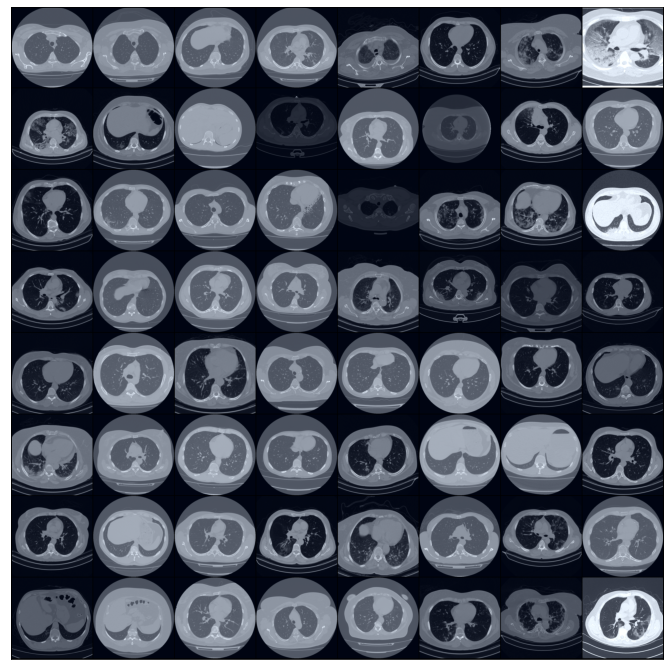

In [13]:
show_batch(dl)

**Availability of NVIDIA CUDA engine.**

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Pretrained MobileNet_V2

In [15]:
class COVID_CT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=True)
        # Replace last layer
        self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    
    def summery(self, input_size):
        return summary(self, input_size)

In [16]:
model = COVID_CT(num_classes=2).to(device)
model.summery((3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [17]:
learning_rate = 0.0001
n_epochs = 100

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [20]:
def evaluate(model, dl, loss_func, device, ds=val_dataset):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [21]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'accuracy': acc, 'validation_loss': val_loss, 'validation_accuracy': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)         

    return history

In [22]:
res = fit(n_epochs, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.1803 - [acc]=0.9283 - [val_loss]=0.0863 - [val_acc]=0.9675


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0593 - [acc]=0.9791 - [val_loss]=0.0861 - [val_acc]=0.9731


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0228 - [acc]=0.9928 - [val_loss]=0.1049 - [val_acc]=0.9565


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0088 - [acc]=0.9974 - [val_loss]=0.0487 - [val_acc]=0.9848


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0073 - [acc]=0.9975 - [val_loss]=0.0570 - [val_acc]=0.9814


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0011 - [acc]=1.0000 - [val_loss]=0.0429 - [val_acc]=0.9862


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0021 - [acc]=0.9993 - [val_loss]=0.0565 - [val_acc]=0.9807


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0127 - [acc]=0.9950 - [val_loss]=0.0928 - [val_acc]=0.9696


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0090 - [acc]=0.9970 - [val_loss]=0.0525 - [val_acc]=0.9876


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0014 - [acc]=0.9996 - [val_loss]=0.0379 - [val_acc]=0.9896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0006 - [acc]=1.0000 - [val_loss]=0.0378 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0002 - [acc]=1.0000 - [val_loss]=0.0455 - [val_acc]=0.9896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0463 - [val_acc]=0.9896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0380 - [val_acc]=0.9896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0002 - [acc]=1.0000 - [val_loss]=0.0352 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0002 - [acc]=1.0000 - [val_loss]=0.0446 - [val_acc]=0.9883


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0003 - [acc]=1.0000 - [val_loss]=0.0363 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0345 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0408 - [val_acc]=0.9896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0397 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0321 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0336 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0325 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0306 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0329 - [acc]=0.9893 - [val_loss]=0.0540 - [val_acc]=0.9834


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0136 - [acc]=0.9955 - [val_loss]=0.0397 - [val_acc]=0.9876


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0045 - [acc]=0.9985 - [val_loss]=0.0580 - [val_acc]=0.9855


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0039 - [acc]=0.9985 - [val_loss]=0.0278 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0029 - [acc]=0.9993 - [val_loss]=0.0804 - [val_acc]=0.9855


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0005 - [acc]=0.9999 - [val_loss]=0.0451 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0347 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0376 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0332 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0327 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0320 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0489 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0001 - [acc]=1.0000 - [val_loss]=0.0362 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0349 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0434 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0309 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0306 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0361 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0358 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0333 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0330 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0345 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0361 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0361 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0287 - [val_acc]=0.9945


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0284 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0277 - [val_acc]=0.9945


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0317 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0285 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0304 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0327 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0385 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0315 - [val_acc]=0.9938


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0330 - [val_acc]=0.9931


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0338 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0360 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0391 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0342 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0402 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0401 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0412 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0343 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0371 - [val_acc]=0.9924


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0363 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0381 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0350 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0687 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0377 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0398 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0376 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0402 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0432 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0348 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0364 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0361 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0514 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0355 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0413 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0391 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0423 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0416 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0432 - [val_acc]=0.9903


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0566 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0383 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0397 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0367 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0380 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0376 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0507 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0426 - [val_acc]=0.9910


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0369 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0394 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0433 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0465 - [val_acc]=0.9917


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0524 - [val_acc]=0.9890


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[loss]=0.0000 - [acc]=1.0000 - [val_loss]=0.0454 - [val_acc]=0.9917


**Results.**

In [39]:
def show_results(history):
    accuracy = [res['accuracy'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['validation_accuracy'] for res in history]
    val_losses = [res['validation_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, label = 'Loss')
    ax1.plot(val_losses, label = 'Validation Loss')
    ax1.legend()
    ax1.set_title("Loss vs Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(100 * np.array(accuracy), label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), label = 'Validation Accuracy')
    ax2.legend();
    ax2.set_title("Accuracy vs Epochs")
    ax2.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    
    fig.show()

**Accuracy and Loss Curves**

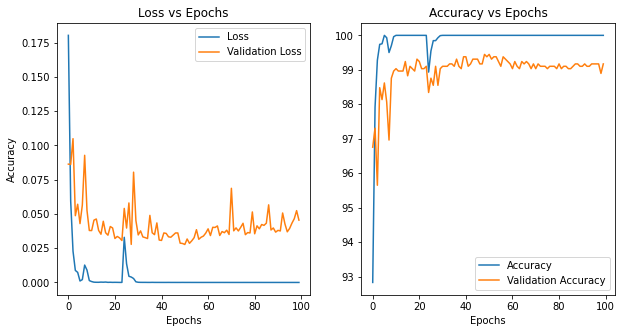

In [40]:
show_results(res)

In [34]:
y_test, y_pred = [], []
for imgs, lbls in tqdm(val_dl):
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    y_test += lbls.tolist()
    y_pred += preds.tolist()


  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

**Confusion Matrix.**

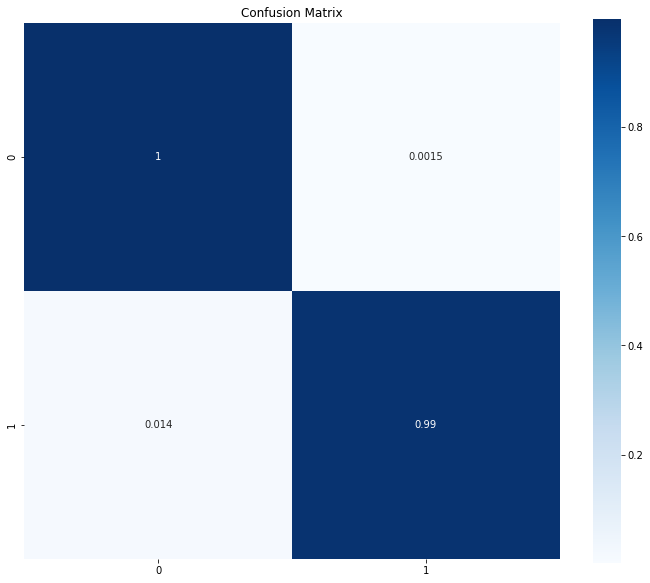

In [27]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

**Classification Report.**

In [35]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       689
           1       1.00      0.99      0.99       759

    accuracy                           0.99      1448
   macro avg       0.99      0.99      0.99      1448
weighted avg       0.99      0.99      0.99      1448

